In [1]:
import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

In [2]:
#First, let's define a "mean" function that we will add noise (and other stuff) to

#Working with sum of Lorentzians with reference widths changed based on T and P
def lorentzian(x, x0, w):
    numer = 0.5*w
    denom = (x - x0)**2 + (0.5*w)**2
    return (1.0/np.pi)*numer/denom


#Need to make the mean function a class that follows GPFlow's style
class MeanFunc(gpflow.mean_functions.MeanFunction):
    
    def __init__(self, locs=[-2.0, 0.0, 5.0], widths=[0.5, 1.0, 4.0]):
        self.locs = gpflow.Parameter(locs, dtype=tf.float64, name='lorentz_loc')
        self.widths = gpflow.Parameter(widths, dtype=tf.float64, name='lorentz_width')

    def __call__(self, xTP):
        #First column is x, next is T, last is P
        xTP = tf.cast(xTP, tf.float64)
        x = xTP[:, :1]
        T = xTP[:, 1:2]
        P = xTP[:, 2:]
        widths = self.widths*tf.math.exp(-1.0/T)
        widths *= tf.math.exp(P)
        lineshapes = lorentzian(tf.reshape(x, (-1, 1)), self.locs, widths)
        line_sum = tf.reduce_sum(lineshapes, axis=1)
        return tf.reshape(line_sum, (-1, 1))


#Now we also need a noise/shift/extra stuff function, just for testing
def create_noise(x):
    rng = np.random.default_rng()
    min_x = np.min(x)
    max_x = np.max(x)
    shift = 0.1*(max_x - min_x) * rng.random()
    base = 0.5*np.sin((x + shift) * (2.0*np.pi/(max_x - min_x)))
    noise = rng.standard_normal(base.shape[0]) * 0.1 * abs(base)
    return base + noise



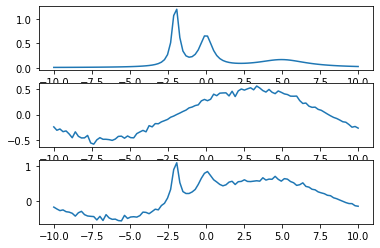

In [3]:
x = np.linspace(-10.0, 10.0, 100)
T = 1.0
P = 1.0
x_in = np.vstack([x, T*np.ones(x.shape[0]), P*np.ones(x.shape[0])]).T
mf = MeanFunc()

fig, ax = plt.subplots(3)
ax[0].plot(x, mf(x_in))
ax[1].plot(x, create_noise(x))
ax[2].plot(x, mf(x_in) + create_noise(x)[:, None])
plt.show()

In [4]:
#We need to create a kernel to use and a mean function
#Note that the parameters in the mean function defined here WILL BE MODIFIED by the fitting procedure
kern = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 1.0, 1.0])
mf = MeanFunc()

#We want to generate data with columns of x, T, P and noise to go with it
x = np.linspace(-10.0, 10.0, 100)
temps = np.array([1.0, 0.1, 2.0])
pressures = np.array([1.0, 1.0, 0.5])
x_dat = []
noise = []
for i in range(temps.shape[0]):
    x_dat.append(np.vstack([x, temps[i]*np.ones(x.shape[0]), pressures[i]*np.ones(x.shape[0])]).T)
    noise.append(create_noise(x))
x_dat = np.vstack(x_dat)
#With x data, can just call the mean function (lazily letting initial parameters be the reference)
orig_y = mf(x_dat)
orig_noise = np.hstack(noise)[:, None]
y_dat = orig_y + orig_noise

#Define our Gaussian process regression model
gpr = gpflow.models.GPR(data=(x_dat, y_dat), kernel=kern, mean_function=mf)

In [5]:
#See the variables in our model
#For the mean function, we just have the 'lorenz_*' variables
#The other variables define the parameters of the noise and covariance matrix
#Note that the covariance matrix will have three lengthscales, 1 each for x, T, and P
#This assumes that these covariances vary INDEPENDENTLY in these directions
gpr.trainable_variables

(<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.54132485, 0.54132485, 0.54132485])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413232726357509>,
 <tf.Variable 'lorentz_loc:0' shape=(3,) dtype=float64, numpy=array([-2.,  0.,  5.])>,
 <tf.Variable 'lorentz_width:0' shape=(3,) dtype=float64, numpy=array([0.5, 1. , 4. ])>)

In [6]:
#Perform optimization (it's L-BFGS-B in scipy by default, but could also use Tensorflow, etc.)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=100))

In [7]:
#Look at the parameters again
gpr

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.locs,Parameter,Identity,,True,"(3,)",float64,[-2.00467308 -0.01630028 5.0279778 ]
GPR.mean_function.widths,Parameter,Identity,,True,"(3,)",float64,[0.50198019 0.99395265 3.91767773]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.22800941926485735
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[5.8683678 3.85751602 1.02398321]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0011879458352881465


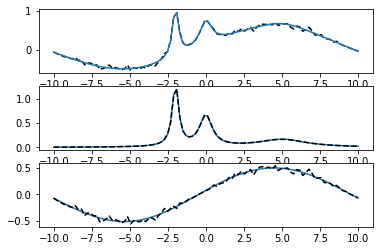

In [8]:
#Check out predictions
#Note that predict_f returns noiseless estimates, which is probably what we want
#But we also get variances in our estimates
#By default the full model is return, which is the mean function added to the rest
#We look at the full fit in the top panel, just the mean function in the middle, and just the "noise" in the bottom
#Remember, the parameters for our mean function have been changed by optimization (see above)

fig, ax = plt.subplots(3)

test_x = x_dat[:x.shape[0], :]
test_y = y_dat[:x.shape[0]]

pred_mean, pred_var = gpr.predict_f(test_x)
ax[0].errorbar(test_x[:, :1], pred_mean, yerr=np.sqrt(np.squeeze(pred_var)))
ax[0].plot(test_x[:, :1], test_y, 'k--')

ax[1].plot(test_x[:, :1], mf(test_x))
ax[1].plot(test_x[:, :1], orig_y[:x.shape[0]], 'k--')

ax[2].plot(test_x[:, :1], pred_mean - mf(test_x))
ax[2].plot(test_x[:, :1], orig_noise[:x.shape[0]], 'k--')